In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")




In [5]:
#from google.colab import drive
#drive.mount('/content/drive/')
#__dir__ = '/content/drive/My Drive/final_project/Flight_Delay_AA/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
#data = pd.read_csv(__dir__+'final_data.csv')
data = pd.read_csv(__dir__+'final_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,3,4,10,11,13,19,20,21,22,30,36,41,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###How to deal with large data frame

In [7]:
data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64
0,2016,1,1,6,3,2016-01-06,AA,19805,AA,N4YBAA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1057,-3.0,0.0,0.0,-1.0,1100-1159,15,1112.0,1424.0,8.0,1438.0,1432,-6.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,155.0,132.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,7,4,2016-01-07,AA,19805,AA,N434AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1056,-4.0,0.0,0.0,-1.0,1100-1159,14,1110.0,1416.0,10.0,1438.0,1426,-12.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,150.0,126.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,8,5,2016-01-08,AA,19805,AA,N541AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1055,-5.0,0.0,0.0,-1.0,1100-1159,21,1116.0,1431.0,14.0,1438.0,1445,7.0,7.0,0.0,0.0,1400-1459,0.0,NaN,0.0,158.0,170.0,135.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,9,6,2016-01-09,AA,19805,AA,N489AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1102,2.0,2.0,0.0,0.0,1100-1159,13,1115.0,1424.0,9.0,1438.0,1433,-5.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,151.0,129.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,10,7,2016-01-10,AA,19805,AA,N439AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1240,100.0,100.0,1.0,6.0,1100-1159,20,1300.0,1617.0,14.0,1438.0,1631,113.0,113.0,1.0,7.0,1400-1459,0.0,NaN,0.0,158.0,171.0,137.0,1.0,986.0,4.0,0.0,0.0,47.0,0.0,66.0,NaN,NaN,NaN,NaN


In [0]:
#we have milions data lets takea sample of them for comparison  
start_date='2016-01-01'
end_date='2016-02-28'
#greater than the start date and smaller than the end date
mask = (data['FL_DATE'] > start_date) & (data['FL_DATE'] <= end_date)

In [0]:
#sample data frame only firts 2 months
sample_df = data.loc[mask]


In [10]:
sample_df.shape #(841136, 65)

(841136, 65)

In [11]:
sample_df.isnull().sum()

YEAR                        0
QUARTER                     0
MONTH                       0
DAY_OF_MONTH                0
DAY_OF_WEEK                 0
                        ...  
LATE_AIRCRAFT_DELAY    711577
FIRST_DEP_TIME         836210
TOTAL_ADD_GTIME        836210
LONGEST_ADD_GTIME      836210
Unnamed: 64            841136
Length: 65, dtype: int64

###Lets Look at our Y###

In [0]:
def is_delay_ARR(data):  #so this is for y - our Y
  if data<=0:  #early
    return False
  if data>0:  #delay
    return True

In [13]:
sample_df["is_ARR_delay"]=sample_df["ARR_DELAY"].apply(is_delay_ARR)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


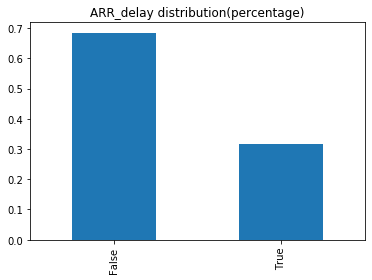

In [14]:
sample_df["is_ARR_delay"].value_counts(normalize=True, sort = True,).plot.bar(title='ARR_delay distribution(percentage)')


###Lets Explore the data###

In [15]:
#lets start with day of week(we need to change the type)
sample_df["DAY_OF_WEEK"] = sample_df["DAY_OF_WEEK"].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

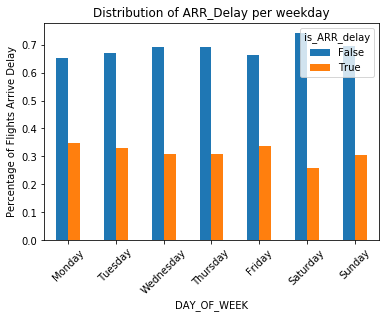

In [16]:
#show the delay on arrival according to days in week
days_delays = sample_df.groupby(['DAY_OF_WEEK', 'is_ARR_delay']).size().unstack().pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  #am i sure that the number is correct versus the days
ax=days_delays.plot.bar(title='Distribution of ARR_Delay per weekday')
ax.set_ylabel('Percentage of Flights Arrive Delay')
ax.set_xticklabels(week, rotation = 45)

In [0]:
#now lets create a feature
def is_Dep_delay_ontime_early(data):  #lets do hot encoding to departure , we can do transformer on it
  if data<0:  #early
    return 1
  if data>0:  #delay
    return 2
  if data ==0:  #on time
    return 3
  else:
    return 0

In [18]:
sample_df["is_DEP_delay_ontime_early"]=sample_df["DEP_DELAY"].apply(is_Dep_delay_ontime_early)
delay_dep_arr = sample_df.groupby(['is_DEP_delay_ontime_early', 'is_ARR_delay']).size().unstack().pipe(lambda df: df.divide(df.sum(axis=1), axis=0))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0, 0, 'early'), Text(0, 0, 'delay'), Text(0, 0, 'ontime')]

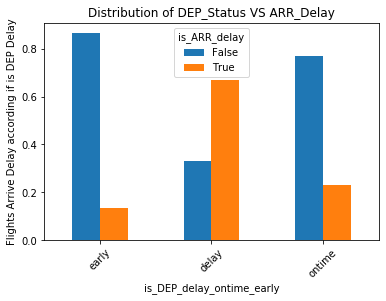

In [19]:
#show the delay on arrival according to days in week
delay_dep_arr = sample_df.groupby(['is_DEP_delay_ontime_early', 'is_ARR_delay']).size().unstack().pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
DEP_Delay_OnTime_Early=["early","delay","ontime"]
ax=delay_dep_arr.plot.bar(title='Distribution of DEP_Status VS ARR_Delay')
ax.set_ylabel('Flights Arrive Delay according if is DEP Delay')
ax.set_xticklabels(DEP_Delay_OnTime_Early, rotation = 45)

In [0]:
###map carrier  , אולי קשר לחברות בד or mayme the time of the flight, or specific carrier
carrier_dict={"WN": 'Southwest Airlines',
 "AA": 'American Airlines',
 "DL": 'Delta Air Lines',
 "OO": 'SkyWest Airlines',
 "EV": 'Atlantic Southeast Airlines',
 "UA": 'United Airlines',
 "B6": 'JetBlue Airways',
 "AS": 'Alaska Airlines, Inc.',#####stopped here
 "NK": 'Spirit Airlines',
 "F9": 'Frontier Airlines',
  "HA": 'Hawaiian Airlines',
 "VX": 'Virgin America'}

In [0]:
def update_carrier_name(data):   #can do transformet here
  return carrier_dict.get(data)

In [22]:
sample_df["UNIQUE_CARRIER_NAME"]=sample_df["UNIQUE_CARRIER"].apply(update_carrier_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Percentage of Carier Vs Delay in Arr')

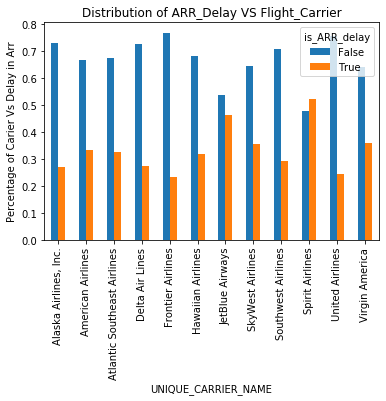

In [23]:

#show the delay on arrival according to Flight carier
carrie_delays = sample_df.groupby(['UNIQUE_CARRIER_NAME', 'is_ARR_delay']).size().unstack().pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
ax=carrie_delays.plot.bar(title="Distribution of ARR_Delay VS Flight_Carrier")
ax.set_ylabel('Percentage of Carier Vs Delay in Arr')

###Feature selection###

In [0]:
#lets try one approch(manually using importance permutation)

##Features_Importance##

In [0]:
#lets create a copy for us to play with
new_df=data.loc[mask]

In [0]:
new_df_clean=new_df.dropna(how='all')

In [0]:
new_df_cat=pd.get_dummies(new_df_clean[:100000])

In [0]:
def is_delay_ARR(data):  #so this is for y - our Y
  if data<=0:  #early
    return False
  if data>0:  #delay
    return True

In [0]:
y=new_df_cat["ARR_DELAY"].apply(is_delay_ARR)

In [0]:
 #create column name withour ARR 
 clean_column_names=[]
for column in new_df_cat.columns:
    if (('ARR_DEL' not in column) and ('ARR_TIME' not in column)):

      clean_column_names.append(column)



In [0]:
X=new_df_cat[clean_column_names]

In [0]:
y=y.fillna(0)
X=X.fillna(0)
y=y.astype('int')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [0]:
#lets do feature selection from the model

In [35]:
from sklearn.feature_selection import SelectFromModel
my_model = RandomForestClassifier(n_estimators=100,random_state=0)  #default clasifier params
my_model.fit(X_train[:5000], y_train[:5000])
#SelectFromModel will select those features which importance is greater than the mean importance of all the features by default, but we can alter this threshold if we want.
sel = SelectFromModel(my_model)
sel.fit(X_train[:5000], y_train[:5000])
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['AIRLINE_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_STATE_FIPS',
       'DEST_STATE_FIPS', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_DELAY',
       'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
       ...
       'TAXI_OUT_43.0', 'TAXI_OUT_44.0', 'TAXI_OUT_45.0', 'TAXI_OUT_46.0',
       'TAXI_OUT_48.0', 'TAXI_OUT_50.0', 'TAXI_OUT_51.0', 'TAXI_OUT_60.0',
       'TAXI_OUT_61.0', 'CANCELLATION_CODE_B'],
      dtype='object', length=799)


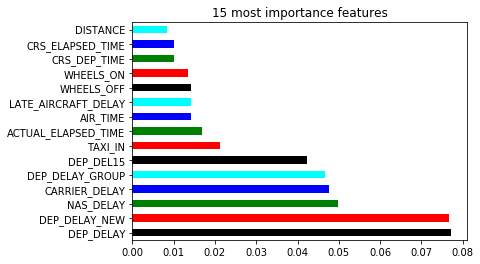

In [36]:
importances = sel.estimator_.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns) 
feat_importances.nlargest(15).plot(title='15 most importance features',kind='barh',color=['black', 'red', 'green', 'blue', 'cyan'])  #top15

In [0]:
y_pred_test = my_model.predict(X_test)
y_pred_test_proba=my_model.predict_proba(X_test)

In [0]:

my_confusion_matrix = confusion_matrix(y_test, y_pred_test)

my_confusion_matrix = pd.DataFrame(my_confusion_matrix, 
                                   index = my_model.classes_, 
                                   columns = my_model.classes_)

In [0]:
def my_normalize(df):
    return pd.DataFrame(normalize(df, norm = 'l1', axis=1), index =  df.index, columns = df.columns)

In [40]:
my_confusion_matrix = my_normalize(my_confusion_matrix)
my_confusion_matrix.stack().sort_values()

print(classification_report(y_test, y_pred_test))  #recall of 0.69  very high number !!!

              precision    recall  f1-score   support

           0       0.83      0.97      0.90     19617
           1       0.91      0.63      0.75     10383

    accuracy                           0.85     30000
   macro avg       0.87      0.80      0.82     30000
weighted avg       0.86      0.85      0.84     30000



###Lets see if we can improve the matric that we got from all the features

#Lets Create our own Features#

In [0]:

new_sample=sample_df.fillna(0)
#new_sample=sample_df.dropna(how='all')

In [0]:
def is_delay_ARR(data):  #so this is for y - our Y
  if data<=0:  #early
    return False
  if data>0:  #delay
    return True

Our Y

In [0]:
y=new_sample["ARR_DELAY"].apply(is_delay_ARR)
y=y.fillna(0)
y=y.astype(int)


###Create aditional Coloumns

###Dep_Time

In [0]:
def round_time(data):
      if len(data)<4:
        return 0
      if 'nan' in data:
        return 0
      if data[2:4]>'30':
        return int(data[:2])+1
      else:
        return int(data[:2])

In [0]:
#maybe the actual deptimein Hour (round the 2 firts digit)
dep_time_str=new_sample["DEP_TIME"].astype(str).str[:4]

new_sample["Actual_DEP_Time"]=dep_time_str
new_sample["date_time_in_hour"] = dep_time_str.apply(round_time).rename("Actual_DEP_Time_In_Hours")

###Easy&West Countries

In [0]:
West_Coast=["Alaska","Washington","Oregon","California","Arizona","Colorado","Idaho","Montana","Nevada","New Mexico"," Utah","Wyoming","Hawaii","Michigan"]
East_Coast=["Maine", "New Hampshire", "Massachusetts", "Rhode Island", "Connecticut", "New York", "New Jersey","Delaware","Maryland", "Virginia", "North Carolina", "South Carolina", "Georgia","Florida"]
def East_or_West(data):
  if data in West_Coast:
    return 1 #"West"
  if data in  East_Coast:
    return 2 #"East"
  else:
    return 0 #none

In [0]:
new_sample["East_West_Origin"]=new_sample["ORIGIN_STATE_NM"].apply(East_or_West)

new_sample["East_West_Dest"]=new_sample["DEST_STATE_NM"].apply(East_or_West)

###Latitude & Longitude read the data and run the transformer in pipeline

In [0]:
#countries_data_df = pd.read_csv(__dir__+'states1.csv')
countries_data_df = pd.read_csv('states1.csv')

In [0]:
df=countries_data_df[[" Name","Latitude","Longitude"]]


###Our X

In [0]:

#X=new_sample.fillna(0)
X=new_sample.dropna()


In [0]:
clean_column_names=[]
for column in X.columns:
  if (('ARR_DEL' not in column) and ('ARR_TIME' not in column) and ('is_ARR_delay' not in column)):
    clean_column_names.append(column)

In [0]:
temp_df=X[clean_column_names]
numeric_features=temp_df.select_dtypes(include=np.number)
numeric_features_names=numeric_features.columns
categorical_features=temp_df.select_dtypes(exclude=np.number)
categorical_features_names=["UNIQUE_CARRIER"]
encrich_features_names=["ORIGIN_STATE_NM","DEST_STATE_NM"]



###CreatePipeLine###

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        #print(feature_names)
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [0]:
#Custom transformer we wrote to engineer features ( bathrooms per bedroom and/or how old the house is in 2019  ) 
#passed as boolen arguements to its constructor
class AddFeatures(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__(self):
      self.start=0
    #Return self, nothing else to do here
    def fit(self, X, y = None ):
      return self 
    
    def is_Dep_delay_ontime_early(self,obj):  #lets do hot encoding to departure , we can do transformer on it
      #print("1")
      if obj<0:  #early
        return 1
      if obj>0:  #delay
        return 2
      if obj ==0:  #on time
        return 3
      else:
        return 0


    #Custom transform method that add relevant features
    def transform(self, X, y = None):
      X.loc[:,'depature_status']=X["DEP_DELAY"].apply(self.is_Dep_delay_ontime_early)
      
      #Converting any infinity values in the dataset to Nan
      X = X.replace( [ np.inf, -np.inf ], np.nan )
      #returns a numpy array
      return X.values

In [0]:
def create_Dummies(data):
  return pd.get_dummies(data)

In [0]:
my_dummies = FunctionTransformer(create_Dummies, validate=False)

In [0]:
class EnrichmentFeatures(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__(self):
      self.Longitude_dict=dict()
      self.Latitude_dict=dict()
      for name in countries_data_df[" Name"]:
        value=df.loc[df[' Name'] == name]
        self.Longitude_dict[name]=value.Longitude
        self.Latitude_dict[name]=value.Latitude
    #Return self, nothing else to do here
    def fit(self, X, y = None ):
        return self 
   
    def get_mean_Latitude_and_Longitude(self,obj):
      if 'Missouri' in obj:
        return 0 #bug inthe 3rd party that we download the data
      if 'U.S.' in obj:
        return 0 #as well bug in org data
      if 'Puerto Rico' in obj:
        return 0 #as w
      a = self.Longitude_dict[obj]
      b = self.Latitude_dict[obj]
      return np.mean([a.values,b.values])
    
    #Custom transform method that add relevant features
    def transform(self, X, y = None):
      X.loc[:,"avg_Latitude_and_Longitude_source"]=X["ORIGIN_STATE_NM"].apply(self.get_mean_Latitude_and_Longitude)
      X.loc[:,"avg_Latitude_and_Longitude_dest"]=X["DEST_STATE_NM"].apply(self.get_mean_Latitude_and_Longitude)
      #drop redundant column 
      X.drop('ORIGIN_STATE_NM', axis = 1,inplace=True)
      X.drop('DEST_STATE_NM', axis = 1,inplace=True)
      return X.values

In [0]:
#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features_names) ),
                                  
                                            ( 'my_dummies', my_dummies ) 
                                         ] )

In [0]:
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numeric_features_names) ),
                                  
                                         ( 'AddFeaturesTransformer', AddFeatures() ),
                                                                
                                          ( 'MinMax', MinMaxScaler() ) 
                                       ] )

In [0]:
Enrichment_pipeline=Pipeline(steps = [ ( 'Enrichment_selector', FeatureSelector(encrich_features_names) ),
                                       ('EnrichmentFeatures',EnrichmentFeatures())
                                      ])

In [0]:
#Combining transformers pieplines into one full big pipeline horizontally 
#using FeatureUnion
full_transformers_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ),                                                   
                                                                ( 'Enrichment_pipeline', Enrichment_pipeline ) ,
                                                                ( 'numerical_pipeline', numerical_pipeline ),
                                                              ] )


In [0]:
my_model = Pipeline([
                  ('my_transformers', full_transformers_pipeline),
                  ("RandomForestclasifier", RandomForestClassifier(n_estimators=50,random_state=0)) #maybe i willadd clasifier
                    ])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [0]:
my_model.fit(X_train[:5000], y_train[:5000])

In [0]:
y_pred_test = my_model.predict(X_test)
y_pred_test_proba=my_model.predict_proba(X_test)

In [0]:
my_confusion_matrix = confusion_matrix(y_test, y_pred_test)

my_confusion_matrix = pd.DataFrame(my_confusion_matrix, 
                                   index = my_model.classes_, 
                                   columns = my_model.classes_)


In [0]:
def my_normalize(df):
    return pd.DataFrame(normalize(df, norm = 'l1', axis=1), index =  df.index, columns = df.columns)


In [68]:
my_confusion_matrix = my_normalize(my_confusion_matrix)
my_confusion_matrix.stack().sort_values()

print(classification_report(y_test, y_pred_test))  #got recall of 0.75 even better that the feature importance!!!!(it was 0.69)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    174555
           1       0.90      0.68      0.78     77786

    accuracy                           0.88    252341
   macro avg       0.89      0.83      0.85    252341
weighted avg       0.88      0.88      0.87    252341



###Cross_Validation

In [0]:
#my_model.get_params()

In [0]:
#lets play with the n_estimators
my_grid = {
           "RandomForestclasifier__n_estimators": [10,50,100]
          }



In [0]:
gscv = GridSearchCV(my_model,my_grid, cv = 5, verbose=1, scoring = "neg_log_loss", n_jobs =10)  #lets run it


In [0]:
gscv.fit(X_train[:5000], y_train[:5000])  #it cant run , alot of data  #~15 minutess(5000 will be fast)

In [0]:
pd.DataFrame(gscv.cv_results_).sort_values("rank_test_score")

In [0]:
gscv.best_params_  #(what that was rank at firts place-1)

In [0]:
#now we will update our model
my_model.set_params(**gscv.best_params_)

In [0]:
#andnow we will fit it and use its probability
my_model.fit(X_train[:100000], y_train[:100000])

In [0]:
y_pred_test = my_model.predict(X_test)
y_pred_test_proba=my_model.predict_proba(X_test)


my_confusion_matrix = confusion_matrix(y_test, y_pred_test)

my_confusion_matrix = pd.DataFrame(my_confusion_matrix, 
                                   index = my_model.classes_, 
                                   columns = my_model.classes_)


In [0]:
def my_normalize(df):
    return pd.DataFrame(normalize(df, norm = 'l1', axis=1), index =  df.index, columns = df.columns)

In [0]:
my_confusion_matrix = my_normalize(my_confusion_matrix)
my_confusion_matrix.stack().sort_values()
print(classification_report(y_test, y_pred_test))  #recal wasnt change so our tree is the saem with 50


###AUC

In [0]:
from sklearn import datasets, metrics
import matplotlib.pyplot as plt

metrics.plot_roc_curve(my_model,X_test[:5000],y_test[:5000])

plt.show()